# Sampling the Formation Energy of a Phosphorus Interstitial in an InP Bulk
An interstitial is a point defect in a bulk crystal structure where an extra atom becomes trapped in an off-lattice site, producing a strain field in the surrounding bulk crystal. The formation energy can be calculated by looking at the energy difference between a configuration containing the point defect, and a reference bulk crystal (accounting for any change in the number of atoms).

The Gaussian Approximation Potentials (GAP) model (provided) is capable of making predictions of the probability distributions on any quantity of interest (provided that quantity is a function of energies, forces, and/or stresses). 

"GAP_Interfaces.py" contains two different means of using the potential: 

"GapQUIP" is a wrapper to the QUantum Interatomic Potentials (QUIP) implementation of GAP in Python-wrapped Fortran. It can predict the mean and variance of the energy of each atom in a structure, assuming that the atomic energies are independantly distributed.

"GapPy" is a Python only implementation of just the atomic energy prediction component of GAP, but with it we are able to predict a full covariance matrix corresponding to the atomic energies, which is derived from the covariance matrices of all bonds, and the covariance matrices between all SOAP vectors.


The aim of this notebook is to explore how well the GAP model matches DFT predictions, and also to see how well the distribution formed from QUIP predicted variances approximates the "true" distribution formed by samples from the "GapPy" predicted mean vector and covariance matrix of atomic energies for each structure.

In [1]:
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
from GAP_Interfaces import GapPy, GapQUIP
from scipy.stats import norm


# Initialise the QUIP ase calculator
gap_calc = GapQUIP()


First, we read the structures, and find the DFT predictions (included in the .xyz files). Then, we use the QUIP calculator to make a prediction of the total energies, and also read off the predicted variance (stored in the extra_results dict, you need to use calc_args='local_gap_variance' on the quippy Potential in order for this to be stored).~

In [2]:
# Read in structures
reference = read("InP_Bulk.xyz")
n = len(reference)

DFT_ref = reference.get_potential_energy()

reference.calc = gap_calc

GAP_ref = reference.get_potential_energy()

# Grab GAP approximation of the total energy variance
GAP_var_ref = np.sum(gap_calc.extra_results["atoms"]["local_gap_variance"])

defect = read("P_Interstitial.xyz")
dft_defect = defect.get_potential_energy()

defect.calc = gap_calc
GAP_defect = defect.get_potential_energy()

# Grab GAP approximation of the total energy variance
GAP_var_defect = np.sum(gap_calc.extra_results["atoms"]["local_gap_variance"])


raw_defect_cov = gap_calc.extra_results["atoms"]["local_gap_variance"]


Next, we instantiate the Python implementation of GAP, and predict the multivariate normal distributions on the atomic energies of both structures

In [3]:
# Initialise Python GAP model (from GAP_Interfaces.py)
gap = GapPy("GAP", "InP_GAP.xml", sigma=0.001)


# Predict the atomic energy per atom, and a covariance matrix associated with the prediction
# for both reference and defect configurations
E_ref, cov_ref = gap.predict_energy(reference)
E_defect, cov_defect = gap.predict_energy(defect)

Now, we draw samples of both distributions (summing across atoms to predict total energies)

In [4]:
# Number of samples of each energy to generate
num_samples = 5000

# Sample the total energy of each config by sampling from the multivariate normal distribution on the atomic energies
bulk_samples = np.random.multivariate_normal(mean=E_ref, cov=cov_ref, size=(num_samples)).sum(axis=-1)

defect_samples = np.random.multivariate_normal(mean=E_defect, cov=cov_defect, size=(num_samples)).sum(axis=-1)


Finally, we calculate a measure of the formation energy for each method, and compare the results.

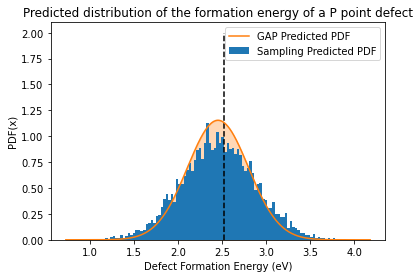

DFT Predicted Formation Energy:  2.5166489833845844  eV
QUIP Predicted Formation Energy:  2.453841334130459  +-  0.3455165601011708  eV
Sampling Predicted Formation Energy:  2.459490743740021  +-  0.4177265432652351  eV


In [14]:
# Calculate formation energies as predicted by our samples

E_formations = defect_samples * n/(n+1) - bulk_samples

DFT_formation = dft_defect * n/(n+1) - DFT_ref

GAP_formation = GAP_defect * n/(n+1) - GAP_ref
var_gap_formation = (GAP_var_defect * (n/(n+1))**2 + GAP_var_ref) * n

# DFT Prediction ("True" value)
plt.vlines(DFT_formation, 0, 2, color="k", linestyles="dashed")

# GAP (QUIP) prediction
x = np.linspace(GAP_formation - 10*var_gap_formation, GAP_formation + 10*var_gap_formation, 1000)
dist= norm.pdf(x, loc=GAP_formation, scale=2*var_gap_formation)
plt.plot(x, dist, color="C1", label="GAP Predicted PDF")
plt.fill_between(x, 0, dist, color="C1", alpha=0.3)

# Prediction via sampling
plt.hist(E_formations, bins=int(num_samples/50), density=True, label="Sampling Predicted PDF")



plt.legend()
plt.xlabel("Defect Formation Energy (eV)")
plt.ylabel("PDF(x)")
plt.title("Predicted distribution of the formation energy of a P point defect")
plt.show()


print("DFT Predicted Formation Energy: ", DFT_formation, " eV")
print("QUIP Predicted Formation Energy: ", GAP_formation, ' +- ', 2*var_gap_formation, " eV")
print("Sampling Predicted Formation Energy: ", np.average(E_formations), " +- ", np.std(E_formations), " eV")